In [1]:
import pandas as pd
import numpy as np

In [3]:
GC_df_12 = pd.read_csv(r"../util/data/FY2013/structured/original/GuilfordCountyOriginalDataFY13.csv")
GC_df_12.drop(['Unnamed: 0'], axis=1,inplace=True)
GC_df_12.head(5)

,page_number,word
0,3,fiscal
1,3,year
2,3,adopted
3,3,budget
4,3,brenda


In [4]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [6]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = GC_df_12.word.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['fiscal']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           passes=10,
                                           alpha = 'auto',
                                           eta = 'auto',
                                           random_state = 1)

pprint(lda_model.print_topics())

[(0,
  '0.193*"revenue" + 0.097*"fiscal" + 0.073*"rate" + 0.048*"law" + '
  '0.046*"require" + 0.046*"increase" + 0.036*"transfer" + 0.034*"purpose" + '
  '0.034*"safety" + 0.031*"manager"'),
 (1,
  '0.123*"total" + 0.088*"prot" + 0.058*"adopt" + 0.054*"facility" + '
  '0.046*"public" + 0.038*"contract" + 0.035*"expense" + 0.034*"commissioner" '
  '+ 0.031*"base" + 0.030*"continue"'),
 (2,
  '0.179*"budget" + 0.168*"property" + 0.071*"provide" + 0.064*"construction" '
  '+ 0.058*"operation" + 0.044*"comm" + 0.037*"appropriate" + 0.031*"employee" '
  '+ 0.030*"local" + 0.027*"source"'),
 (3,
  '0.145*"overlay" + 0.101*"program" + 0.100*"protection" + 0.094*"operate" + '
  '0.078*"ordinance" + 0.056*"estimate" + 0.047*"follow" + 0.047*"support" + '
  '0.036*"subtotal" + 0.035*"function"'),
 (4,
  '0.222*"sale" + 0.093*"debt" + 0.085*"system" + 0.066*"building" + '
  '0.056*"change" + 0.055*"planning" + 0.049*"college" + 0.041*"priority" + '
  '0.033*"establish" + 0.031*"amendment"'),
 (5

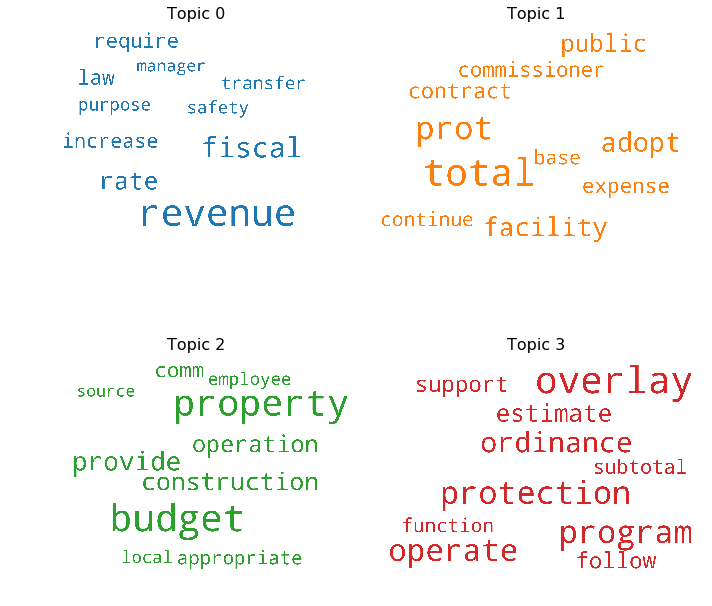

In [9]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

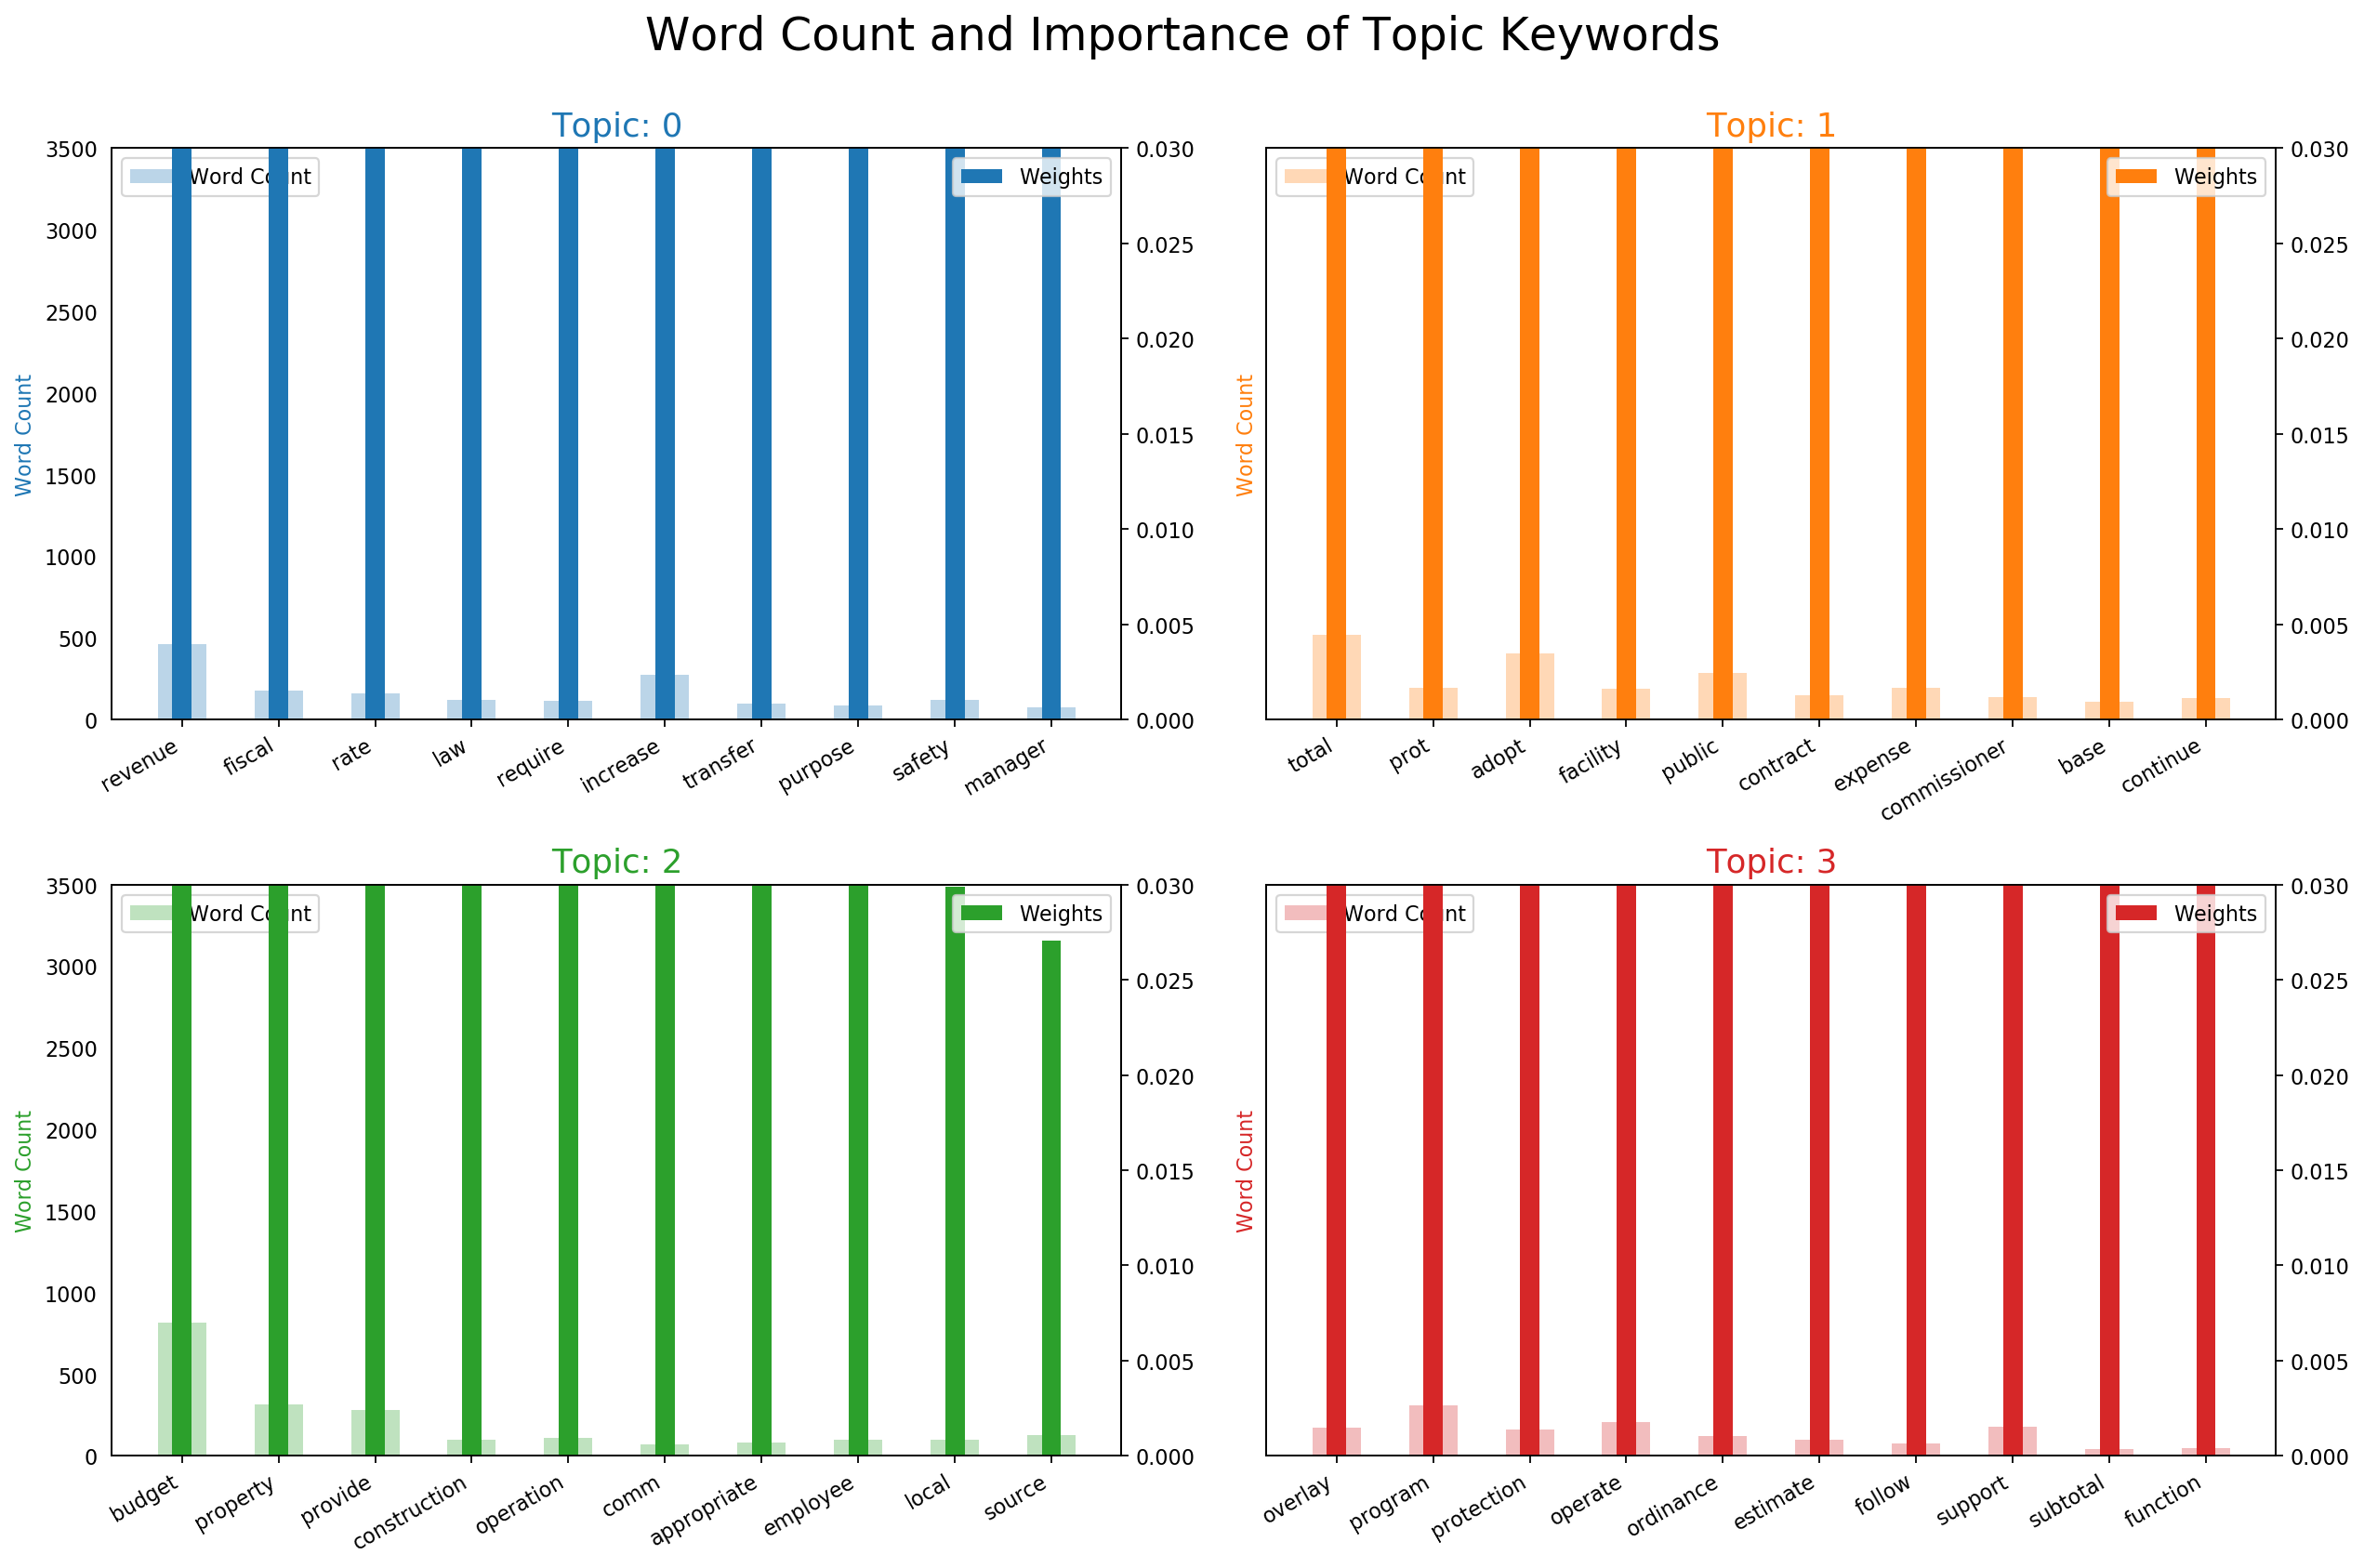

In [10]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [12]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.433523 -0.020650       1        1  16.964254
2     -0.049098 -0.056512       2        1  11.235442
0     -0.051088 -0.054146       3        1  11.180021
8     -0.040033 -0.095098       4        1  10.412291
9     -0.025734  0.422023       5        1  10.136068
6     -0.055137 -0.038155       6        1   9.772840
5     -0.053934 -0.038238       7        1   8.818054
3     -0.053560 -0.041184       8        1   7.815127
7     -0.052124 -0.042010       9        1   7.191373
4     -0.052814 -0.036029      10        1   6.474528, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
139   Default  1345.000000           fire  1345.000000  30.0000  30.0000
56    Default  1003.000000            tax  1003.000000  29.0000  29.0000
16    Default  1039.000000        service  1039.000000  28.0000  28.0000
212   Default  1061.000000           dist  1061.000000  27.0000  27.0000
38    Default   833.000000        revenue   833.000000  26.0000  26.0000
1     Default   745.000000           year   745.000000  25.0000  25.0000
3     Default   777.000000         budget   777.000000  24.0000  24.0000
59    Default   728.000000       property   728.000000  23.0000  23.0000
61    Default   557.000000           sale   557.000000  22.0000  22.0000
134   Default   625.000000        project   625.000000  21.0000  21.0000
141   Default   810.000000          total   810.000000  20.0000  20.0000
45    Default   585.000000           fund   585.000000  19.0000  19.0000
213   Default   439.000000        overlay   439.000000  18.0000  18.0000
242   Default   577.000000           prot   577.000000  17.0000  17.0000
218   Default   414.000000  appropriation   414.000000  16.0000  16.0000
39    Default   408.000000    expenditure   408.000000  15.0000  15.0000
99    Default   353.000000        capital   353.000000  14.0000  14.0000
0     Default   419.000000         fiscal   419.000000  13.0000  13.0000
181   Default   354.000000        include   354.000000  12.0000  12.0000
193   Default   305.000000        program   305.000000  11.0000  11.0000
97    Default   304.000000     protection   304.000000  10.0000  10.0000
131   Default   284.000000        operate   284.000000   9.0000   9.0000
151   Default   306.000000         amount   306.000000   8.0000   8.0000
57    Default   314.000000           rate   314.000000   7.0000   7.0000
177   Default   307.000000        provide   307.000000   6.0000   6.0000
2     Default   379.000000          adopt   379.000000   5.0000   5.0000
49    Default   234.000000           debt   234.000000   4.0000   4.0000
229   Default   261.000000        current   261.000000   3.0000   3.0000
101   Default   238.000000        funding   238.000000   2.0000   2.0000
103   Default   355.000000       facility   355.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
1432  Topic10     0.146140       visually     1.457518   0.4374  -9.7473
1431  Topic10     0.146140     timeliness     1.457518   0.4374  -9.7473
1264  Topic10     0.146140      advertise     1.457511   0.4374  -9.7473
1427  Topic10     0.146140     fellowship     1.457518   0.4374  -9.7473
1426  Topic10     0.146140     internship     1.457518   0.4374  -9.7473
535   Topic10     0.146140           icon     1.457518   0.4374  -9.7473
1425  Topic10     0.146140      nowexpire     1.457518   0.4374  -9.7473
1422  Topic10     0.146140     consulting     1.457518   0.4374  -9.7473
1152  Topic10     0.146140        advance     1.457506   0.4374  -9.7473
937   Topic10     0.146140     convenient     1.457501   0.4374  -9.7473
1574  Topic10     0.146141         advise     1.457602   0.4373  -9.7473
2022  Topic10     0.146141     uniqueness     1.457592   0.4373  -9.7473
2021  Topic10     0.1461

In [13]:
dictionary=corpora.Dictionary(data_ready)

In [14]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.8256146597574272


In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

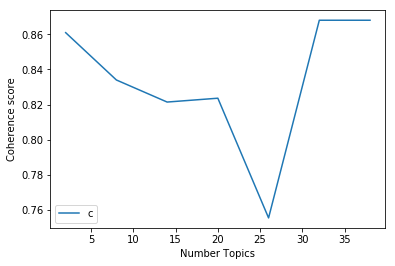

In [16]:
from gensim.models.ldamodel import LdaModel
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=data_ready, start=2, limit=40, step=6)
# Graphs shows the optimal number of topics
import matplotlib.pyplot as plt
%matplotlib inline
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()